In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import matplotlib
from PIL import Image
import pyximport
pyximport.install(language_level=3)
from semantic_analysis.knowledge_base import filter_kb_histograms, get_sup_ent_lists

json_path_kb_histograms = '../COCO/kb/pairwiseKB.json'
charts_path = '../COCO/kb/charts'

if not os.path.isdir(charts_path):
    os.makedirs(charts_path)

with open(json_path_kb_histograms, 'r') as f:
    json_data = json.load(f)


def transform_kb(t, kb):
    transformed_kb = {pair : transform_hist(t, h) for pair, h in kb}
    return transformed_kb

def clean_histogram(h):
    h_clean = {}
    nclasses = len(h)-2
    for c,freq in h.items():
        if c=="entropy" or c=="sup":
            continue
        if freq>1/nclasses:
            h_clean[c]=round(freq,3)
    return h_clean

def convert_pair(pair):
    el = pair.split(",")
    return el[0], el[1]

sup, ent = get_sup_ent_lists(json_data)

## Distribution of histograms support
Support is distributed normally, after log10 transformation.

Outliers: sup>43009, logsup>4.633562868052691
Num outliers = 8
Median(sup): 64


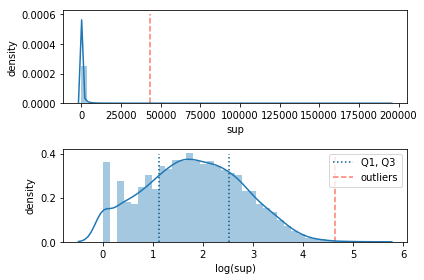

In [2]:
logsup = np.log10(sup)
fig, ax = plt.subplots(2,1)
sns.distplot(sup, ax=ax[0]);
ax[0].set_xlabel("sup")
ax[0].set_ylabel("density")
sns.distplot(logsup, ax=ax[1]);
ax[1].set_xlabel("log(sup)")
ax[1].set_ylabel("density")
plt.tight_layout()

## Find Q1, Q3 and outliers
q1, med, q3 = np.quantile(logsup, [0.25, 0.5, 0.75])
iqr = q3-q1
low = q1-1.5*iqr
high = q3+1.5*iqr
ax[1].vlines([q1,q3],0,0.4, color='#045a8d', linestyle=':', label="Q1, Q3")
ax[1].vlines([high],0,0.4, color='#fb8072', linestyle='--', label="outliers")
ax[0].vlines([int(10**high)],0,0.0006, color='#fb8072', linestyle='--', label="outliers")
l = ax[1].legend()

print(f"Outliers: sup>{int(round(10**high))}, logsup>{high}")
print(f"Num outliers = {(logsup>high).sum()}")
print(f"Median(sup): {int(round(10**med))}")

** What are the 8 outliers? **
They all include person (the most common object).

In [3]:
outliers = [(pair,h) for pair, h in json_data.items() if h['sup']>=int(10**high)]
outliers_clean = []
for pair, h in outliers:
    outliers_clean.append((pair, clean_histogram(h)))
outliers_clean

[('person,sky-other-merged', {'below': 0.792, 'hanging': 0.122}),
 ('person,tree-merged', {'below': 0.456, 'hanging': 0.327}),
 ('person,person',
  {'below': 0.131, 'hanging': 0.128, 'on': 0.153, 'side': 0.248}),
 ('building-other-merged,person',
  {'above': 0.342, 'around': 0.175, 'on': 0.356}),
 ('pavement-merged,person', {'below': 0.393, 'hanging': 0.35}),
 ('chair,person',
  {'above': 0.161, 'below': 0.225, 'hanging': 0.136, 'side': 0.126}),
 ('person,wall-other-merged',
  {'below': 0.223, 'hanging': 0.365, 'inside': 0.137}),
 ('person,road', {'above': 0.531, 'on': 0.22})]

## Entropy analysis
- Analyze entropy distribution with and without filtering supports

Note that **irregularities** and peaks are removed when filtering supports (this means that removing **untrusted** histograms is better).

Reference entropy values. Entr@2=0.69; entr@3=1.1
Num histograms, with ent < entr@3 = 1608


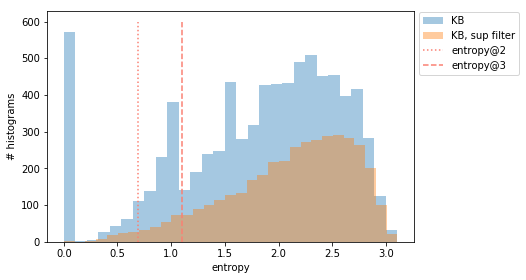

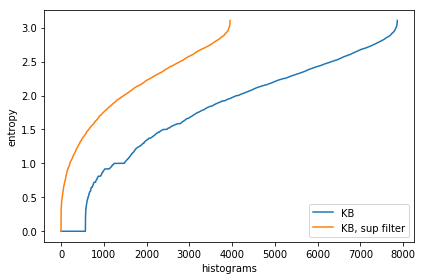

In [4]:
# Filter kb by support
minsup = int(round(10**med))
filtered_kb_minsup = filter_kb_histograms(json_data, minsup, 1000)
_, ent_filtered_kb_minsup = get_sup_ent_lists(filtered_kb_minsup)

# Reference entropy values
entr2 = entropy([0.5,0.5])
entr3 = entropy([1/3,1/3,1/3])
entr4 = entropy([1/4,1/4,1/4,1/4])

print(f"Reference entropy values. Entr@2={round(entr2,2)}; entr@3={round(entr3,2)}")
print(f"Num histograms, with ent < entr@3 = {(ent<entr3).sum()}")

# Distribution
fig, ax = plt.subplots()
sns.distplot(ent, ax=ax, norm_hist=False, kde=False, label="KB");
sns.distplot(ent_filtered_kb_minsup, ax=ax, norm_hist=False, kde=False, label="KB, sup filter")
ax.set_xlabel("entropy")
ax.set_ylabel("# histograms")
plt.tight_layout()

ax.vlines([entr2],0,600, color='#fb8072', linestyle=':', label="entropy@2")
ax.vlines([entr3],0,600, color='#fb8072', linestyle='--', label="entropy@3")
l = ax.legend(bbox_to_anchor=(1.3,0.7), loc="lower right")

# Simple plot
fig, ax = plt.subplots()
ax.plot(np.arange(len(ent)), np.sort(ent), label="KB");
ax.plot(np.arange(len(ent_filtered_kb_minsup)), np.sort(ent_filtered_kb_minsup), label="KB, sup filter")
ax.set_xlabel("histograms")
ax.set_ylabel("entropy")
plt.tight_layout()
l = ax.legend(bbox_to_anchor=(1,0), loc="lower right")

## Aggregation of position classes

entr3:
last 4, **last 6**. last 10.


Top 6 aggregation pairs (entr 3):
-	**below, hanging**: 1218
-	**side-down, below**: 1091
-	below, above: 1077       <-- very strange
-	**side-up, above**: 1077
-	**above, on**: 1045
-	inside, below: 1022     <-- very strange
---------------------------------
-	side-down, hanging: 950
-	side, below: 941
-	inside, above: 929
-	side-up, on: 906

===============================

entr2:
last 3. **last 5**. last 7.

Top 6 aggregation pairs (entr 2):
-   **side-down, below**: 474
-	**below, hanging**: 415
-	**side-up, above**: 388
-	**above, on**: 288
-	inside, below: 281
--------------------------------
-	side-down, hanging: 262
-	below, above: 261
-	side, below: 247
-	around, below: 243
-	around, above: 238

Worst 3 aggregation pairs:
-	around, inside: 774     -- good
-	side-down, around: 793  -- good
-	side-up, hanging: 796   -- good

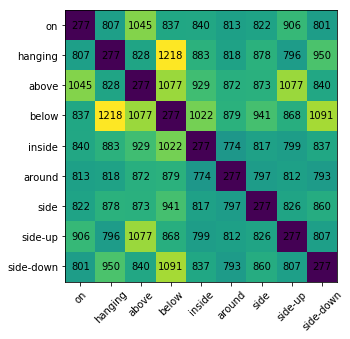

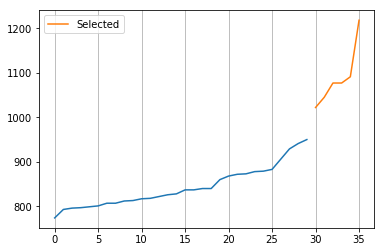

In [5]:
from config import position_labels_csv_path

def transform_hist(transform, hist):
    t_hist = {}
    for c,v in hist.items():
        if c=='entropy' or c=='sup':
            continue
        if c in transform:
            c = transform[c]
        if c in t_hist:
            t_hist[c]+=v
        else:
            t_hist[c]=v
    t_hist['entropy']=entropy(list(t_hist.values()))
    t_hist['sup']=hist['sup']
    return t_hist

with open(position_labels_csv_path,'r') as f:
    positions = ([l.strip() for l in f.readlines()])

select_entropy = entr3
# Try to aggregate all the possible pair of classes
# Make computations for histograms with sup>minsup
ent_stat=np.full([len(positions), len(positions)],(ent_filtered_kb_minsup<=select_entropy).sum())
for i,p1 in enumerate(positions):
    for j,p2 in enumerate(positions):
        if p1!=p2:
            t = {p1:p2}
            transformed_kb_i = transform_kb(t, filtered_kb_minsup.items())
            _, ent_transformed_kb_i = get_sup_ent_lists(transformed_kb_i)
            num_sel = (ent_transformed_kb_i<=select_entropy).sum()
            ent_stat[i,j]=num_sel

# Plot
cmap = matplotlib.cm.get_cmap('Spectral')

fig,ax = plt.subplots(1,1, figsize=[8,5])
ax.imshow(ent_stat)
ax.set_xticks(np.arange(len(positions)))
ax.set_xticklabels(positions, rotation=45)
ax.set_yticks(np.arange(len(positions)))
ax.set_yticklabels(positions)

for i in range(len(positions)):
    for j in range(len(positions)):
        text = ax.text(j, i, ent_stat[i, j],
                       ha="center", va="center", color="black")

plt.show()

vals=[]
for i in range(len(positions)):
    for j in range(len(positions)):
        if i<j:
            vals.append(ent_stat[i, j])
plt.figure()
plt.plot(np.sort(np.array(vals))[:-6])
plt.plot(np.arange(len(vals))[-6:], np.sort(np.array(vals))[-6:], label="Selected")
#plt.gca().set_xticks(range(0,36))
plt.legend()
plt.gca().xaxis.grid()

In [6]:
# Find best aggregations:
best_aggregations = []
worst_aggregations = []
print("Top 6 aggregation pairs:")
x,y = np.unravel_index(ent_stat.argsort(axis=None)[:-14:-1], ent_stat.shape)
for x_i,y_i in zip(x,y):
    if (x_i>y_i):
        best_aggregations.append({positions[x_i] : positions[y_i]})
        print(f"\t{positions[x_i]}, {positions[y_i]}: {ent_stat[x_i,y_i]}")
print("Worst 3 aggregation pairs:")
x,y = np.unravel_index(ent_stat.argsort(axis=None)[:15], ent_stat.shape)
for x_i,y_i in zip(x,y):
    if (x_i>y_i):
        worst_aggregations.append({positions[x_i] : positions[y_i]})
        print(f"\t{positions[x_i]}, {positions[y_i]}: {ent_stat[x_i,y_i]}")

Top 6 aggregation pairs:
	below, hanging: 1218
	side-down, below: 1091
	below, above: 1077
	side-up, above: 1077
	above, on: 1045
	inside, below: 1022
Worst 3 aggregation pairs:
	around, inside: 774
	side-down, around: 793
	side-up, hanging: 796


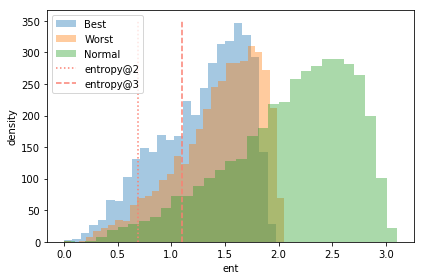

In [7]:
tBest = {'below' : 'hanging'}
_, ent_tBest = get_sup_ent_lists(transform_kb(tBest, filtered_kb_minsup.items()))
tWorst = {'around' : 'inside'}
_, ent_tWorst = get_sup_ent_lists(transform_kb(tWorst, filtered_kb_minsup.items()))

fig, ax = plt.subplots()
sns.distplot(ent_tBest, ax=ax, label='Best', kde=False, norm_hist=False);
sns.distplot(ent_tWorst, ax=ax, label='Worst', kde=False, norm_hist=False, );
sns.distplot(ent_filtered_kb_minsup, ax=ax, label='Normal', kde=False, norm_hist=False);
ax.set_xlabel("ent")
ax.set_ylabel("density")
plt.tight_layout()

ax.vlines([entr2],0,350, color='#fb8072', linestyle=':', label="entropy@2")
ax.vlines([entr3],0,350, color='#fb8072', linestyle='--', label="entropy@3")
l = ax.legend()

- Note that **Best** aggregation **changes** the distribution and maximizes the number of lower entropies.
- **Worst** aggregation implies only a **translation** of the distribution

Let's verify this:

Best aggregations, by type.
floor-other-merged,rock-merged {'below': 0.284, 'hanging': 0.305}
pizza,sandwich {'side-down': 0.158, 'below': 0.285}
book,book {'below': 0.271, 'above': 0.228}
backpack,dog {'above': 0.245, 'side-up': 0.236}
cow,pavement-merged {'above': 0.269, 'on': 0.336}
car,mirror-stuff {'below': 0.271, 'hanging': 0.124, 'inside': 0.347}


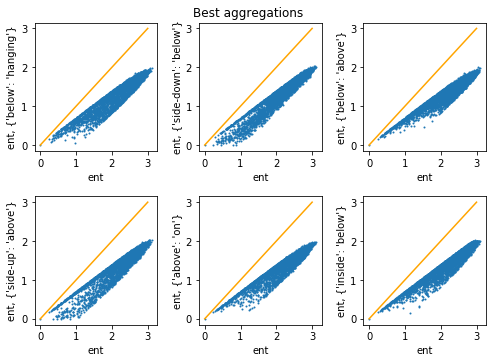

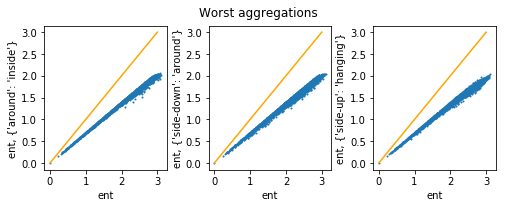

In [8]:
plt.figure(figsize=[7,5])
plt.suptitle("Best aggregations", y=1)
print("Best aggregations, by type.")
for i, tBest in enumerate(best_aggregations):
    ax = plt.subplot(2, 3, i+1)
    transformed_kb_i = transform_kb(tBest, filtered_kb_minsup.items())
    _, ent_transformed_kb_i = get_sup_ent_lists(transformed_kb_i)
    
    # Select best change
    best_transform_index = (np.array(ent_filtered_kb_minsup) - np.array(ent_transformed_kb_i)).argsort()[-1]
    best_transform = list(filtered_kb_minsup.items())[best_transform_index]
    print(best_transform[0], clean_histogram(best_transform[1]))
    
    ax.scatter(ent_filtered_kb_minsup, ent_transformed_kb_i, s=1)
    ax.plot(np.linspace(0,3), np.linspace(0,3), color="orange")
    ax.set_ylabel(f"ent, {tBest}")
    ax.set_xlabel("ent")
plt.tight_layout()

plt.figure(figsize=[7,5])
plt.suptitle("Worst aggregations", y=1)
for i, tWorst in enumerate(worst_aggregations):
    ax = plt.subplot(2, 3, i+1)
    transformed_kb_i = transform_kb(tWorst, filtered_kb_minsup.items())
    _, ent_transformed_kb_i = get_sup_ent_lists(transformed_kb_i)
      
    ax.scatter(ent_filtered_kb_minsup, ent_transformed_kb_i, s=1)
    ax.plot(np.linspace(0,3), np.linspace(0,3), color="orange")
    ax.set_ylabel(f"ent, {tWorst}")
    ax.set_xlabel("ent")
plt.tight_layout()

- As you can see, **Worst** aggregations are **linearly dependent** with originl entropy.
It just means that the entropy values decrease all together only because 1 position class has been removed.
- **Best** aggregations, instead are more "scattered" because the transformation has a very good benefit to a subset of the histograms (i.e. those where the merged classes have **similar semantic meaning**).

Moreover, examples of good merge:
- 'floor-other-merged', 'rock-merged' {'below': 0.284, 'hanging': 0.305} -> **Below+hanging**
- 'pizza', 'sandwich' {'side-down': 0.158, 'below': 0.285} -> **Side-down+below**
- 'book', 'book' {'below': 0.271, 'above': 0.228} -> **above+blow**
- 'backpack', 'dog' {'above': 0.245, 'side-up': 0.236} -> **above+side-up**
- 'cow', 'pavement-merged' {'above': 0.269, 'on': 0.336} -> **above+on**
- 'car', 'mirror-stuff' {'below': 0.271, 'hanging': 0.124, 'inside': 0.347} -> **below+hanging**

For example book is above or below other books.

## Selection of best histograms
We pick histograms with $sup>median$ and $ent<ent@3$

Number of selected histograms: 277


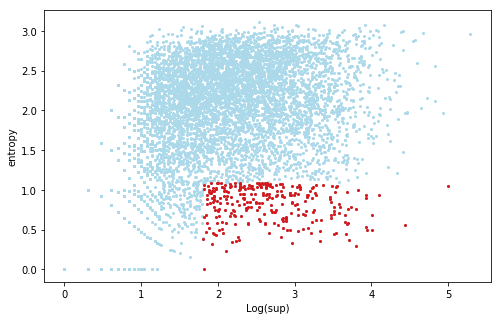

In [9]:
# Filter histograms
filtered_kb = filter_kb_histograms(json_data, minsup, entr3)
sup_filtered, ent_filtered = get_sup_ent_lists(filtered_kb)
print(f"Number of selected histograms: {len(filtered_kb)}")

# Plot scatterplot
plt.figure(figsize=(8, 5))
plt.plot(np.log10(sup), ent, c='#abd9e9', linestyle='', marker='o', markersize=2)
plt.xlabel("Log(sup)")
plt.ylabel("entropy")
plt.grid()
plt.plot(np.log10(sup_filtered), ent_filtered, c='#d7191c', linestyle='', marker='o', markersize=2)
plt.grid()

## Experiments of image retrieval

In [10]:
from config import train_graphs_json_path
from semantic_analysis.visualization import filter_graphs_with_local_data

with open(train_graphs_json_path, "r") as f:
    tot_graphs = json.load(f)
    
entr3 = entropy([1/3,1/3,1/3])
minsup = 64
filtered_kb = filter_kb_histograms(json_data, minsup, entr3)
sup_filtered, ent_filtered = get_sup_ent_lists(filtered_kb)

graphs = filter_graphs_with_local_data(tot_graphs)

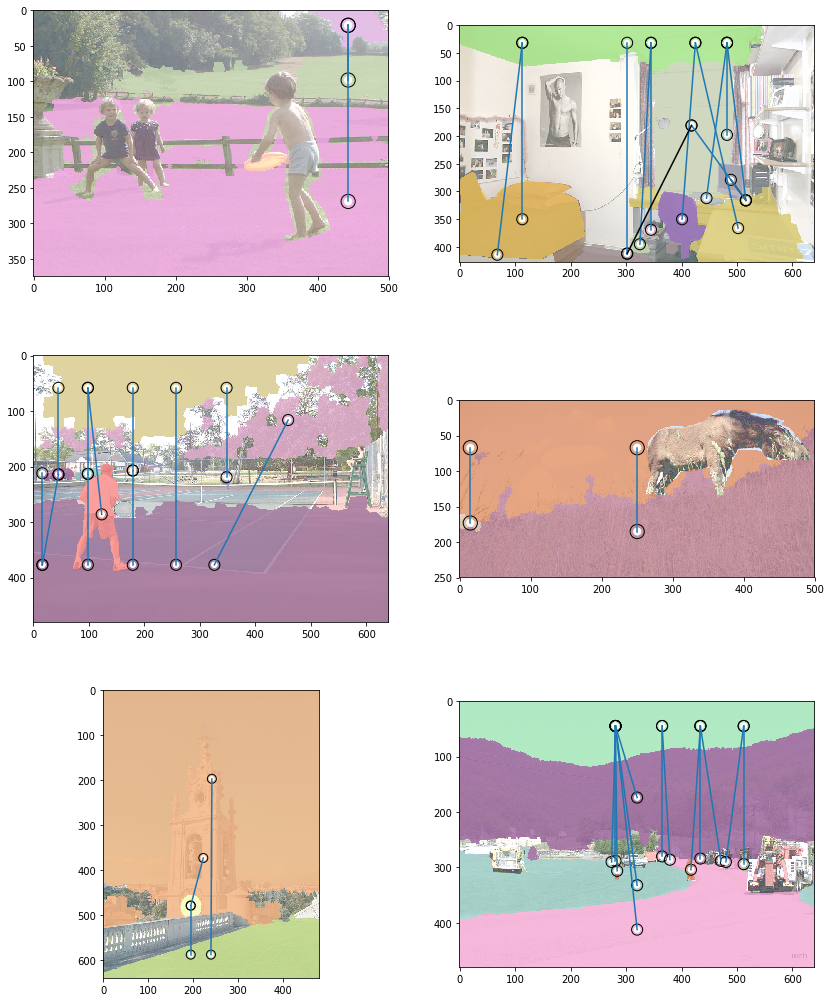

In [11]:
%load_ext autoreload
%autoreload
from semantic_analysis.visualization import RelationshipVisualizer
from panopticapi.utils import id2rgb
import seaborn as sns
import cv2
    
image_ids = [30238, 36841,499952,36397,518377,499932]
plt.figure(figsize=[14,18])
for i, image_id in enumerate(image_ids):
    for g in graphs:
        if g['graph']['name']==image_id:
            break
    ax = plt.subplot(3,2,i+1)
    rv = RelationshipVisualizer(image_id, ax)
    rv.draw_positive_relationships(g, filtered_kb, 0.1)